In [1]:
3*5

15

In [2]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR

import matplotlib.pyplot as plt

#### Inputs

In [3]:
crypto_currency = "BTC" # cryptocurrency of interest (str)
currency = "USD" # currency to convert into (str)
nb_data = 5000 # number of data points (int)

#### Functions definition

In [4]:
# Converts unix timestamp into readable date
def convert_time(timestamp):
    # timestamp: unix timestamp (int)
    return datetime.datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')


# Get dataframe containing hourly prices until a given timestamp
def get_hourly_series(crypto_currency, currency, nb_data, last_timestamp):
    # crypto_currency: cryptocurrency of interest (str)
    # currency: target currency (str)
    # nb_data: number of data points to output (int)
    # last_timestamp: unix timestamp (int)
    
    url = "https://min-api.cryptocompare.com/data/histohour?fsym={0}&tsym={1}&limit={2}&toTs={3}"
    series = []
    
    
    while nb_data > 2000:
        
        # Request 2000 last data points before (including) "last_timestamp". 2001 is the maximum number of points
        # that can be requested at once
        url_temp = url.format(crypto_currency,currency,"1999",last_timestamp)
        data = requests.get(url_temp.format(crypto_currency)).json()
        
        # Update the series
        series = data["Data"] + series
        
        # Update timestamp and the number of data points to query before sending new request
        last_timestamp = series[0]["time"]-1
        nb_data = nb_data - 2000
    
    # Final request (once the number of data points to get dropped below 2000)
    url_temp = url.format(crypto_currency,currency,str(nb_data-1),last_timestamp)
    data = requests.get(url_temp.format(crypto_currency)).json()
    
    # Update the time series
    if nb_data == 1:
        series = [data["Data"][1]] + series
    else:
        series = data["Data"] + series
    
    return pd.DataFrame(series)

#### Get the time series

In [5]:
time_series = get_hourly_series(crypto_currency, currency, nb_data, int(time.time()))

init_time = time_series.iloc[0]["time"]
time_series["date"] = time_series["time"].apply(convert_time)
time_series["hour"] = ((time_series["time"]-init_time)/3600).astype(int)
time_series["ln_open"] = np.log(time_series["open"])

#### Plots of the prices, their logarithm and autocorrelation

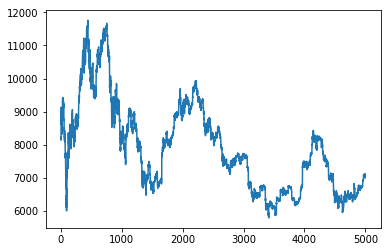

In [6]:
plt.plot(time_series["hour"],time_series["open"])

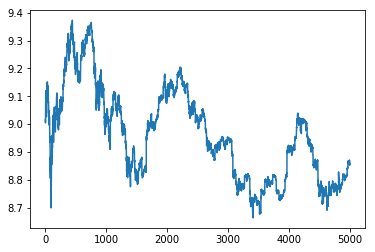

In [7]:
plt.plot(time_series["hour"],time_series["ln_open"])

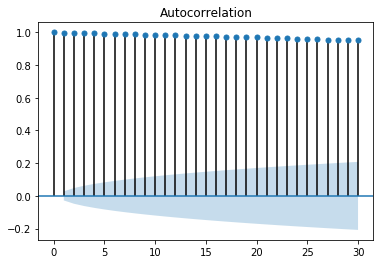

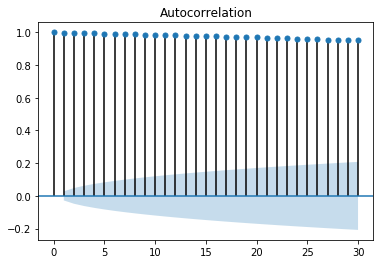

In [8]:
plot_acf(time_series["ln_open"], lags=30)

#### Order of the AR model unknown
The fit() method determines the order, around 32

In [9]:
TS = time_series["ln_open"].values

predictions_1h = []
predictions_6h = []

test = TS[len(TS)-100:]

# For each new hour, fit the model and predict the 6 next hours
for i in range(0,100):
    train = TS[i:len(TS)-100+i] 
    model = AR(train)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+5, dynamic=False)
    predictions_1h = predictions_1h + [np.exp(predictions[0])]
    predictions_6h = predictions_6h + [np.exp(predictions[5])]

    
# Get the errors in the predictions
error_square_1h = (np.array(predictions_1h)-np.exp(test))*(np.array(predictions_1h)-np.exp(test))
error_square_6h = (np.array(predictions_6h[:-5])-np.exp(test[5:]))*(np.array(predictions_6h[:-5])-np.exp(test[5:]))
error_1h = np.sqrt(np.mean(error_square_1h))
error_6h = np.sqrt(np.mean(error_square_6h))

print("Std dev for 1h predictions:", error_1h)
print("Std dev for 6h predictions:", error_6h)

Std dev for 1h predictions: 28.832881261506216
Std dev for 6h predictions: 63.21566666376355


##### Plot of the predictions and realisations

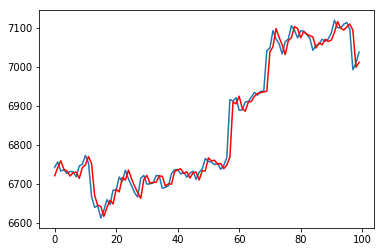

In [10]:
plt.plot(np.exp(test))
plt.plot(predictions_1h, color='red')

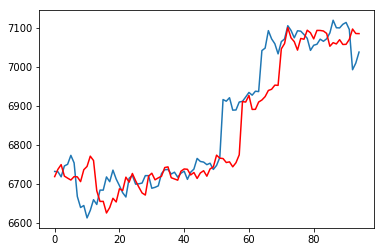

In [11]:
plt.plot(np.exp(test[5:]))
plt.plot(predictions_6h[:-5], color='red')

#### Order of the AR set to 1

In [12]:
TS = time_series["ln_open"].values

predictions_1h = []
predictions_6h = []

test = TS[len(TS)-100:]

# For each new hour, fit the model and predict the 6 next hours
for i in range(0,100):
    train = TS[i:len(TS)-100+i] 
    model = AR(train)
    model_fit = model.fit(maxlag = 1)
    predictions = model_fit.predict(start=len(train), end=len(train)+5, dynamic=False)
    predictions_1h = predictions_1h + [np.exp(predictions[0])]
    predictions_6h = predictions_6h + [np.exp(predictions[5])]

    
# Get the errors in the predictions
error_square_1h = (np.array(predictions_1h)-np.exp(test))*(np.array(predictions_1h)-np.exp(test))
error_square_6h = (np.array(predictions_6h[:-5])-np.exp(test[5:]))*(np.array(predictions_6h[:-5])-np.exp(test[5:]))
error_1h = np.sqrt(np.mean(error_square_1h))
error_6h = np.sqrt(np.mean(error_square_6h))

print("Std dev for 1h predictions:", error_1h)
print("Std dev for 6h predictions:", error_6h)

Std dev for 1h predictions: 28.895807442541585
Std dev for 6h predictions: 65.44795683356158


##### Plot of the predictions and realisations

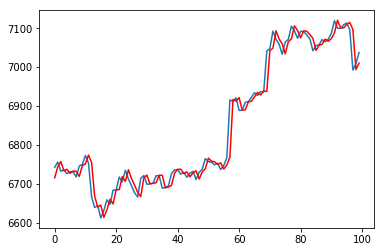

In [13]:
plt.plot(np.exp(test))
plt.plot(predictions_1h, color='red')

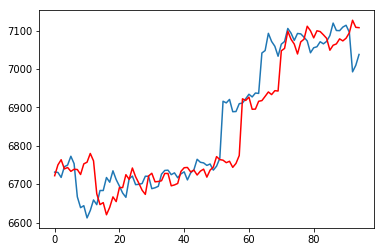

In [14]:
plt.plot(np.exp(test[5:]))
plt.plot(predictions_6h[:-5], color='red')

#### Correlation with other cryptocurrencies

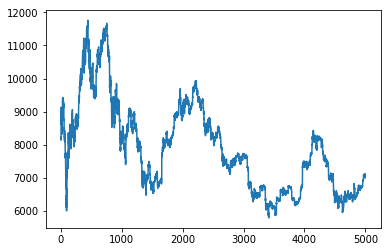

In [18]:
time_series = get_hourly_series(crypto_currency, currency, nb_data, int(time.time()))

init_time = time_series.iloc[0]["time"]
time_series["date"] = time_series["time"].apply(convert_time)
time_series["hour"] = ((time_series["time"]-init_time)/3600).astype(int)
time_series["ln_open"] = np.log(time_series["open"])

plt.plot(time_series["hour"],time_series["open"])

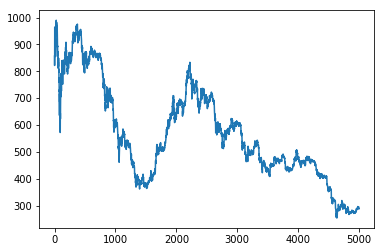

In [16]:
time_series = get_hourly_series("ETH", currency, nb_data, int(time.time()))

init_time = time_series.iloc[0]["time"]
time_series["date"] = time_series["time"].apply(convert_time)
time_series["hour"] = ((time_series["time"]-init_time)/3600).astype(int)

plt.plot(time_series["hour"],time_series["open"])

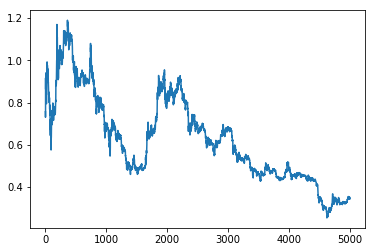

In [17]:
time_series = get_hourly_series("XRP", currency, nb_data, int(time.time()))

init_time = time_series.iloc[0]["time"]
time_series["date"] = time_series["time"].apply(convert_time)
time_series["hour"] = ((time_series["time"]-init_time)/3600).astype(int)

plt.plot(time_series["hour"],time_series["open"])